In [1]:
from sklearn.model_selection import train_test_split
from ipynb.fs.full.EEG_Toolbox import *
from sklearn.preprocessing import StandardScaler , LabelEncoder
import sys, io
import pandas as pd 
import pickle
from ipynb.fs.full.Data_Processing import *

In [2]:
window_size_list = [1,2,5,10,15,30]

window_size_samples = 30
clean_tf = pd.read_csv("clean_trainingfiles.csv")
dt = generate_all_samples(clean_tf, window_size_samples, window_size_samples)

# saved_file = "/cs/home/ybk1/Dissertation/data/all_tests_EEG.pickle"
# with open(saved_file, 'rb') as handle:
#     all_tests = pickle.load(handle)

    
# sampled_file = "/cs/home/ybk1/Dissertation/data/User_1_sampled_annotated_EEG.pickle"
# with open(sampled_file, 'rb') as handle:
#     dt = pickle.load(handle)

# data = all_tests[1]
# # filter using bandpass
# inputs = array(data.iloc[:,:-6])
# filtered = chebyBandpassFilter(inputs, [0.9, 1, 40, 42], gstop=40, gpass=1, fs=2048.)[1]

import numpy as np
import torch
torch.backends.cudnn.benchmark = True



# X = [filtered[i:i+window_size_samples]
#      for i in range(data.shape[0] - window_size_samples)]
X = np.array(dt["inputs"]).transpose(0,2,1).astype(np.float32)
# y = np.array(data.iloc[window_size_samples:,-3]).astype(np.int64) - 1
y = dt['attention']
#Convert the categories into labels 
le = LabelEncoder()
y =  le.fit_transform(y)


print(X.shape)
print(y.shape)

Processing user 1 , test 10


TypeError: get_samples_from_test() missing 2 required positional arguments: 'slider' and 'sample_size'

In [37]:
from braindecode.datasets.xy import create_from_X_y
import time
time_start = time.time()
train_X, X_test, train_y, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.20, random_state=42, stratify=train_y)


means = train_X.mean(axis=(0,2), keepdims=True)
stds = train_X.std(axis=(0,2), keepdims=True)
 
# standardize per channel
train_X = (train_X - means) / (stds)
valid_X = (valid_X - means) / (stds)
X_test = (X_test - means) / (stds)

save_stdout = sys.stdout
sys.stdout = open('trash', 'w')
train_set = create_from_X_y(train_X, train_y, drop_last_window=False)
valid_set = create_from_X_y(valid_X, valid_y, drop_last_window=False)
sys.stdout = save_stdout

print('Datasets created! Time elapsed: {} seconds'.format(time.time()-time_start))


Datasets created! Time elapsed: 4.899339914321899 seconds


In [38]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet , Deep4Net


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=5
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

# model =  ShallowFBCSPNet(
#     n_chans,
#     n_classes,
#     input_window_samples=input_window_samples,
#     final_conv_length="auto",
# )

model =  Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length="auto", pool_time_length=1,
        pool_time_stride=1,
)

# Send model to GPU
if cuda:
    model.cuda()



Loading data for 1 events and 60 original time points ...
Loading data for 1 events and 60 original time points ...


In [39]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
time_start = time.time()
from braindecode import EEGClassifier
# These values we found good for shallow network:
# lr = 0.0625 * 0.01
# weight_decay = 0

# For deep4 they should be:
lr = 1 * 0.01
weight_decay = 0.5 * 0.001

batch_size = 32
n_epochs = 500

sys.stdout = open('trash', 'w')

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)
sys.stdout = save_stdout
print('Training completed created! Time elapsed: {} seconds'.format(time.time()-time_start))

/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 389.41767716407776 seconds


In [40]:


clf.score(X_test,y_test), clf.score(valid_X,valid_y) , clf.score(train_X,train_y)


(0.6714285714285714, 0.6294642857142857, 0.64501679731243)

In [41]:
y_pred_test = clf.predict(X_test)

In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[1 2 3 4 5]
[1 2 3 4 5]
Confusion matrix, without normalization
[[  5   0  11   0   0]
 [  0  67  78   0   0]
 [  0   8 249  41  29]
 [  0   0  91  92  29]
 [  0   0  17  13 163]]


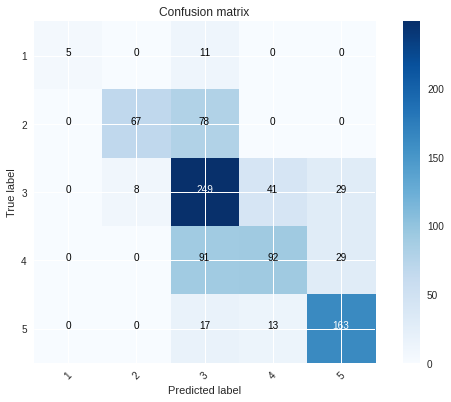

In [43]:
from sklearn.metrics import confusion_matrix
import itertools
print(le.classes_)
y_pred = le.inverse_transform(clf.predict(train_X))
print(le.classes_)
y_true = le.inverse_transform(train_y)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, le.classes_)


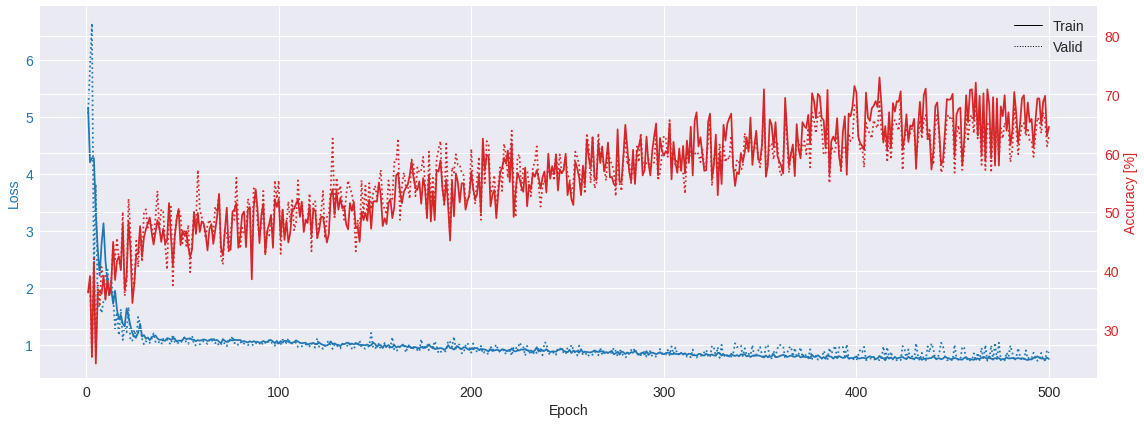

In [44]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 * df.train_accuracy,
               valid_misclass=100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Accuracy [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [45]:
# # save model 
# saved_file = "models/attention_user_1_with_fi.pickle"
# with open(saved_file, 'wb') as handle:            
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)